In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import warnings
warnings.filterwarnings('ignore')

In [40]:
np.random.seed(42)


df = pd.read_csv('breast-cancer-dataset.csv')

In [41]:
print("Dataset shape:", df.shape)
print("\nFirst 5 rows of the dataset:")
print(df.head())

Dataset shape: (213, 11)

First 5 rows of the dataset:
   S/N  Year  Age  Menopause Tumor Size (cm) Inv-Nodes Breast Metastasis  \
0    1  2019   40          1               2         0  Right          0   
1    2  2019   39          1               2         0   Left          0   
2    3  2019   45          0               4         0   Left          0   
3    4  2019   26          1               3         0   Left          0   
4    5  2019   21          1               1         0  Right          0   

  Breast Quadrant History Diagnosis Result  
0     Upper inner       0           Benign  
1     Upper outer       0           Benign  
2     Lower outer       0           Benign  
3     Lower inner       1           Benign  
4     Upper outer       1           Benign  


In [43]:
# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())
# Replace '#' with NaN
df = df.replace('#', np.nan)


Missing values in each column:
S/N                 0
Year                0
Age                 0
Menopause           0
Tumor Size (cm)     0
Inv-Nodes           0
Breast              0
Metastasis          0
Breast Quadrant     0
History             0
Diagnosis Result    0
dtype: int64


In [44]:
# Check data types and convert columns to appropriate types
print("\nData types before conversion:")
print(df.dtypes)


Data types before conversion:
S/N                  int64
Year                object
Age                  int64
Menopause            int64
Tumor Size (cm)     object
Inv-Nodes           object
Breast              object
Metastasis          object
Breast Quadrant     object
History             object
Diagnosis Result    object
dtype: object


In [45]:
# Convert numeric columns to appropriate types
numeric_cols = ['Age', 'Tumor Size (cm)', 'Inv-Nodes']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
print(df.dtypes)

S/N                   int64
Year                 object
Age                   int64
Menopause             int64
Tumor Size (cm)     float64
Inv-Nodes           float64
Breast               object
Metastasis           object
Breast Quadrant      object
History              object
Diagnosis Result     object
dtype: object


In [46]:
# Handle missing values
print("\nMissing values after conversion:")
print(df.isnull().sum())


Missing values after conversion:
S/N                 0
Year                1
Age                 0
Menopause           0
Tumor Size (cm)     1
Inv-Nodes           1
Breast              6
Metastasis          1
Breast Quadrant     2
History             2
Diagnosis Result    0
dtype: int64


In [47]:
# Fill missing values with median for numeric columns
for col in numeric_cols:
    df[col] = df[col].fillna(df[col].median())

In [50]:
# Fill missing categorical values with mode
categorical_cols = ['Year', 'Menopause', 'Breast', 'Metastasis', 'Breast Quadrant', 'History']
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

In [51]:
# Check for missing values after imputation
print("\nMissing values after imputation:")
print(df.isnull().sum())


Missing values after imputation:
S/N                 0
Year                0
Age                 0
Menopause           0
Tumor Size (cm)     0
Inv-Nodes           0
Breast              0
Metastasis          0
Breast Quadrant     0
History             0
Diagnosis Result    0
dtype: int64


In [52]:
# Encode categorical variables
label_encoder = LabelEncoder()
df['Diagnosis Result'] = label_encoder.fit_transform(df['Diagnosis Result'])
df['Breast'] = label_encoder.fit_transform(df['Breast'])
df['Breast Quadrant'] = label_encoder.fit_transform(df['Breast Quadrant'])

In [53]:
# Data distribution and insights
print("\nTarget variable distribution:")
print(df['Diagnosis Result'].value_counts())
print("\nCorrelation with diagnosis result:")
correlation = df.corr()['Diagnosis Result'].sort_values(ascending=False)
print(correlation)


Target variable distribution:
Diagnosis Result
0    120
1     93
Name: count, dtype: int64

Correlation with diagnosis result:
Diagnosis Result    1.000000
Inv-Nodes           0.771358
Metastasis          0.740473
Tumor Size (cm)     0.688225
Age                 0.531123
Breast Quadrant     0.330641
History             0.192847
Breast              0.101249
S/N                -0.009545
Year               -0.017088
Menopause          -0.381529
Name: Diagnosis Result, dtype: float64


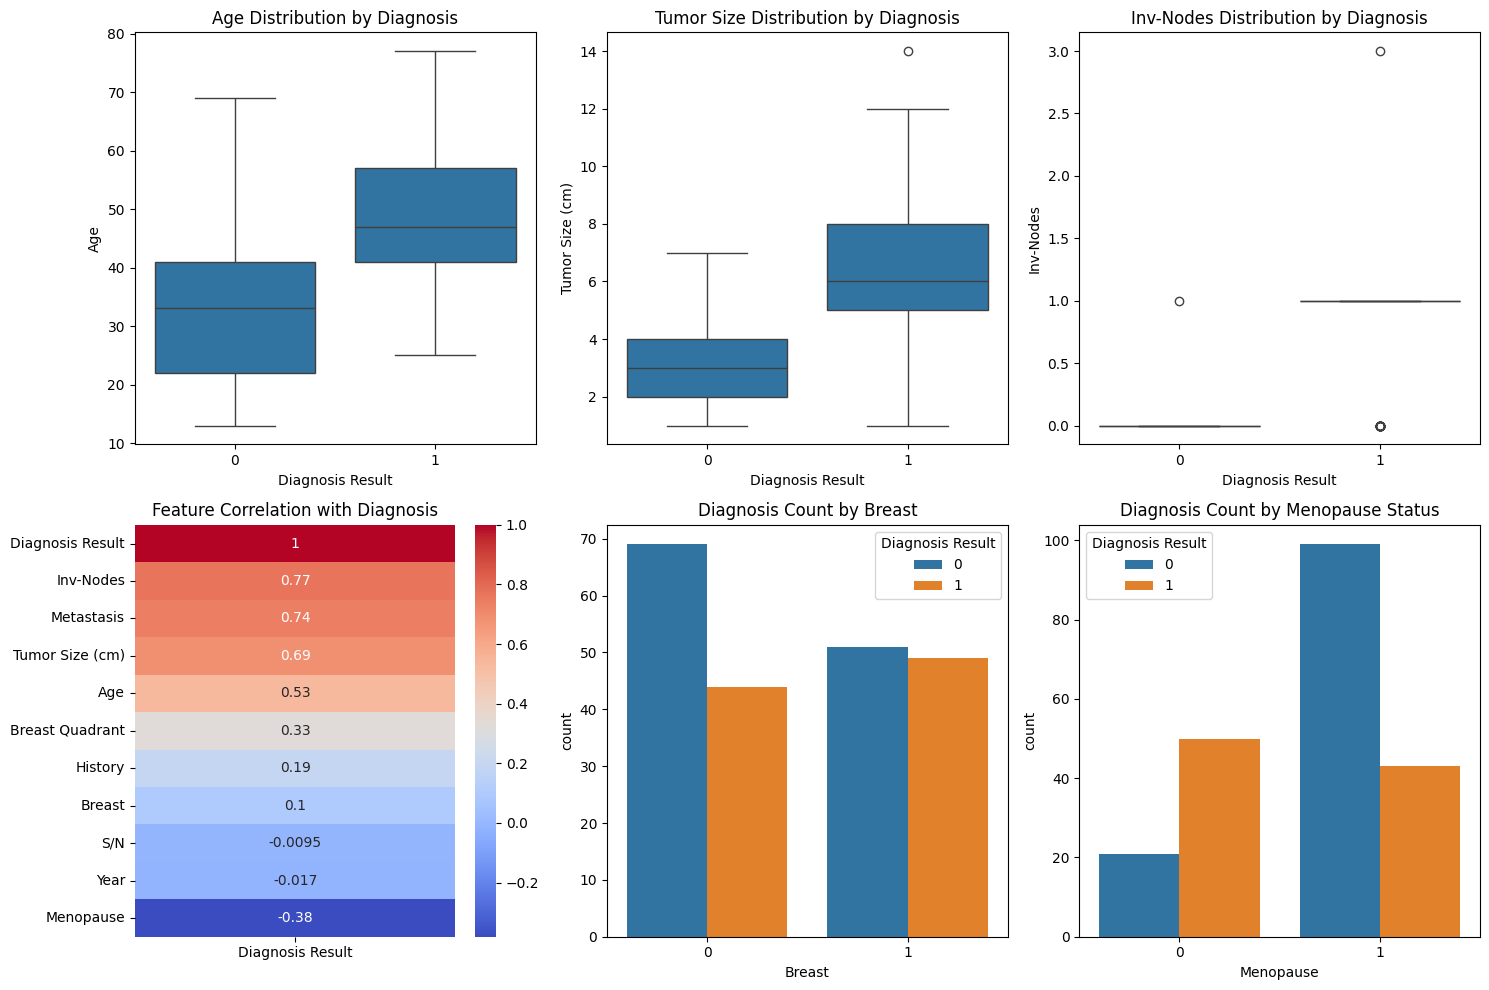

In [54]:
# 2. Data Visualization

# Create a function for plotting
def plot_distributions():
    plt.figure(figsize=(15, 10))
    
    # Age distribution by diagnosis
    plt.subplot(2, 3, 1)
    sns.boxplot(x='Diagnosis Result', y='Age', data=df)
    plt.title('Age Distribution by Diagnosis')
    
    # Tumor Size distribution by diagnosis
    plt.subplot(2, 3, 2)
    sns.boxplot(x='Diagnosis Result', y='Tumor Size (cm)', data=df)
    plt.title('Tumor Size Distribution by Diagnosis')
    
    # Inv-Nodes distribution by diagnosis
    plt.subplot(2, 3, 3)
    sns.boxplot(x='Diagnosis Result', y='Inv-Nodes', data=df)
    plt.title('Inv-Nodes Distribution by Diagnosis')
    
    # Correlation heatmap
    plt.subplot(2, 3, 4)
    sns.heatmap(correlation.to_frame(), annot=True, cmap='coolwarm')
    plt.title('Feature Correlation with Diagnosis')
    
    # Count of diagnosis by breast
    plt.subplot(2, 3, 5)
    sns.countplot(x='Breast', hue='Diagnosis Result', data=df)
    plt.title('Diagnosis Count by Breast')
    
    # Count of diagnosis by menopause status
    plt.subplot(2, 3, 6)
    sns.countplot(x='Menopause', hue='Diagnosis Result', data=df)
    plt.title('Diagnosis Count by Menopause Status')
    
    plt.tight_layout()
    plt.savefig('breast_cancer_distributions.png')
    # plt.show()

# Call the plotting function
plot_distributions()

In [55]:
# 3. Feature Selection and Engineering

# Drop S/N as it's just an identifier
df = df.drop('S/N', axis=1)

In [56]:
# Separate features and target variable
X = df.drop('Diagnosis Result', axis=1)
y = df['Diagnosis Result']

In [57]:
# Apply feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
print("\nFeatures after scaling (first 5 rows):")
print(X_scaled.head())


Features after scaling (first 5 rows):
       Year       Age  Menopause  Tumor Size (cm)  Inv-Nodes    Breast  \
0 -1.053048  0.015356   0.707107        -0.885837  -0.695519  1.063015   
1 -1.053048 -0.055749   0.707107        -0.885837  -0.695519 -0.940721   
2 -1.053048  0.370884  -1.414214        -0.104540  -0.695519 -0.940721   
3 -1.053048 -0.980123   0.707107        -0.495189  -0.695519 -0.940721   
4 -1.053048 -1.335651   0.707107        -1.276486  -0.695519  1.063015   

   Metastasis  Breast Quadrant   History  
0     -0.7221         0.291077 -0.830949  
1     -0.7221         1.164306 -0.830949  
2     -0.7221        -0.582153 -0.830949  
3     -0.7221        -1.455383  1.203443  
4     -0.7221         1.164306  1.203443  


In [58]:
# 4. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")


Training set shape: (170, 9)
Testing set shape: (43, 9)


In [70]:
# 5. Model Training and Evaluation

# Define a function to evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Cross-validation score
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_scaled, y, cv=cv, scoring='accuracy')
    
    # Print results
    print(f"\n{model_name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Cross-Validation Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    
    # Generate classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.savefig(f'confusion_matrix_{model_name.replace(" ", "_").lower()}.png')
    # plt.show()
    
    # ROC curve and AUC score for probabilistic models
    if hasattr(model, "predict_proba"):
        probas = model.predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, probas)
        auc = roc_auc_score(y_test, probas)
        
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {auc:.4f})')
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {model_name}')
        plt.legend(loc='lower right')
        plt.savefig(f'roc_curve_{model_name.replace(" ", "_").lower()}.png')
        # plt.show()
        
        print(f"AUC Score: {auc:.4f}")
    
    return {
        'model_name': model_name,
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'cv_score': cv_scores.mean()
    }

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Extra Trees': ExtraTreesClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42),
    'LightGBM': lgb.LGBMClassifier(random_state=42,is_unbalance=True, verbose=-1),
    'CatBoost': cb.CatBoostClassifier(random_state=42, verbose=0),
    'SVC': SVC(probability=True, random_state=42),
    'Gaussian Naïve Bayes': GaussianNB()
}



Training Logistic Regression...

Logistic Regression Results:
Accuracy: 0.9070
Precision: 1.0000
Recall: 0.7895
F1 Score: 0.8824
Cross-Validation Accuracy: 0.9013 ± 0.0236

Classification Report:
              precision    recall  f1-score   support

           0       0.86      1.00      0.92        24
           1       1.00      0.79      0.88        19

    accuracy                           0.91        43
   macro avg       0.93      0.89      0.90        43
weighted avg       0.92      0.91      0.91        43

AUC Score: 0.9539

Training Random Forest...

Random Forest Results:
Accuracy: 0.8837
Precision: 0.9375
Recall: 0.7895
F1 Score: 0.8571
Cross-Validation Accuracy: 0.8873 ± 0.0180

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.96      0.90        24
           1       0.94      0.79      0.86        19

    accuracy                           0.88        43
   macro avg       0.89      0.87      0.88        43
w

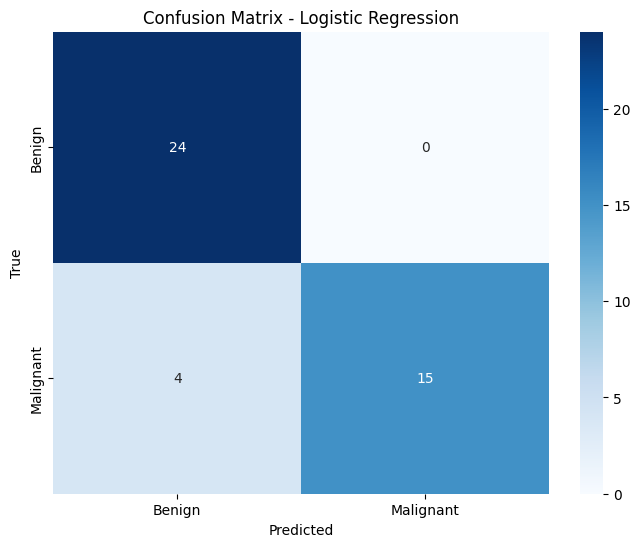

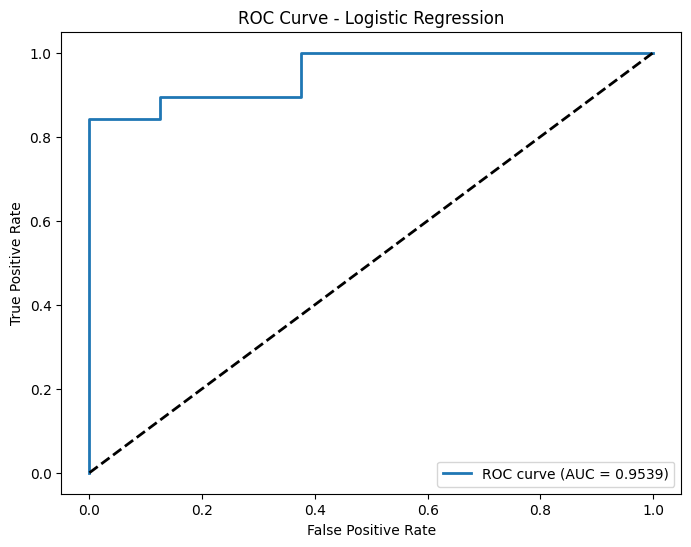

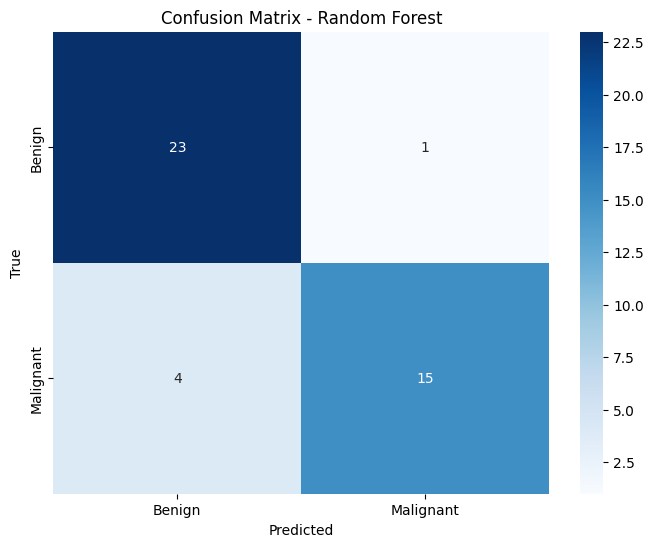

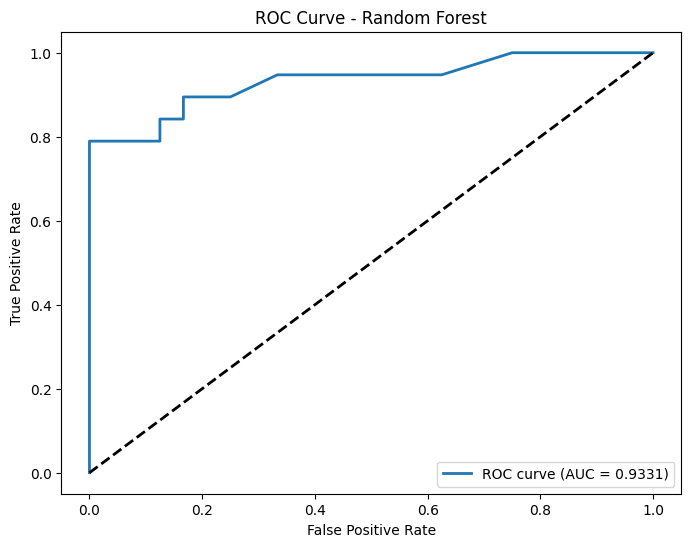

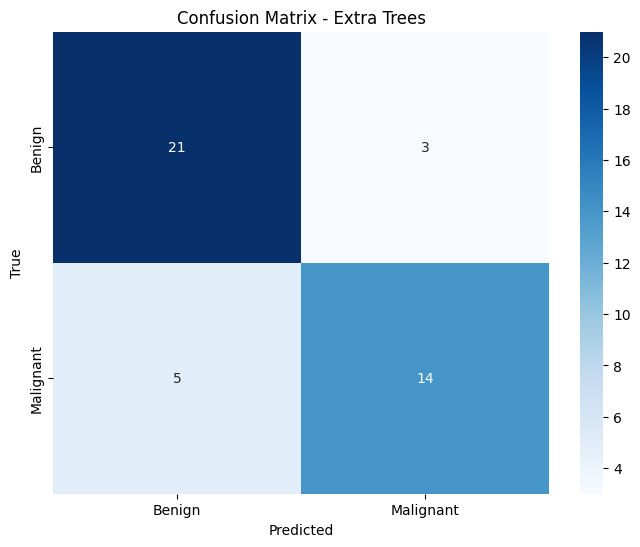

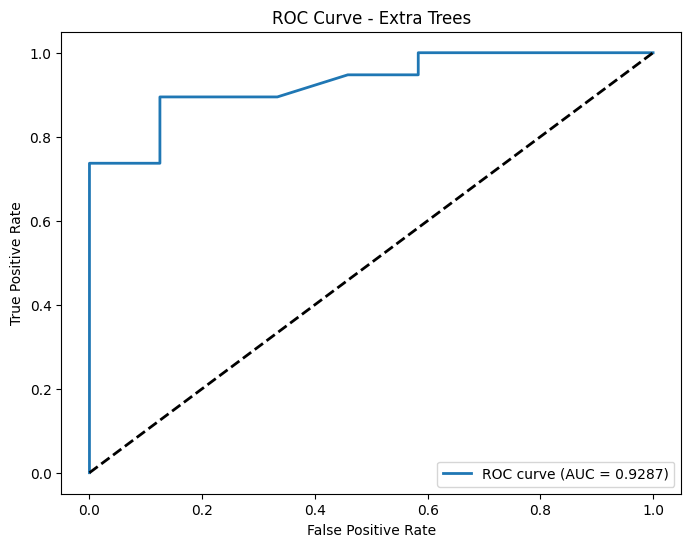

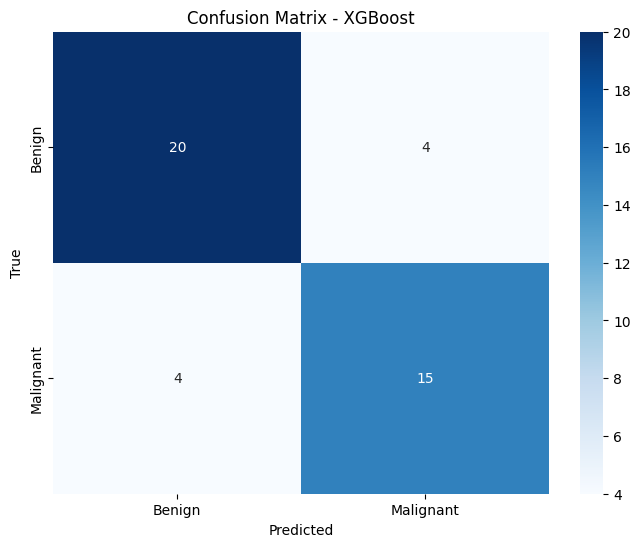

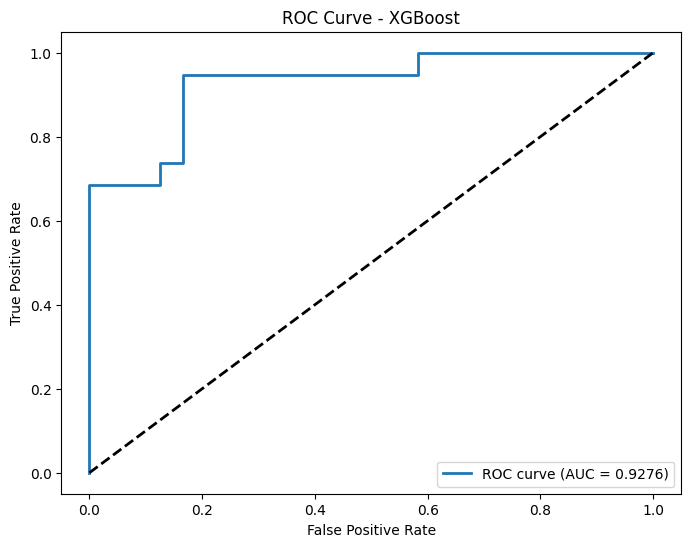

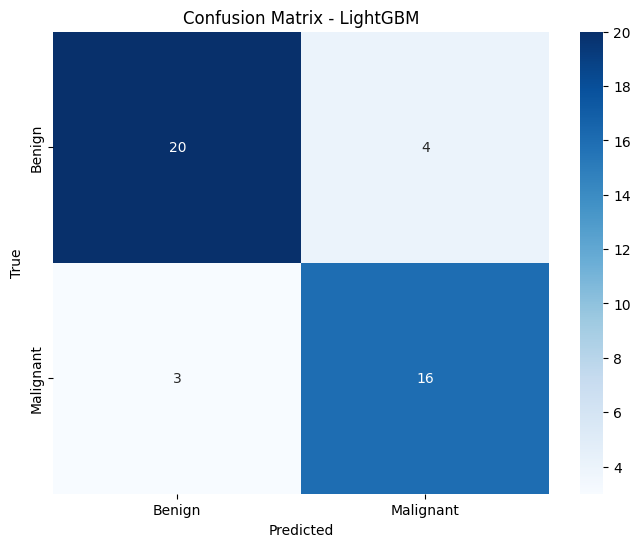

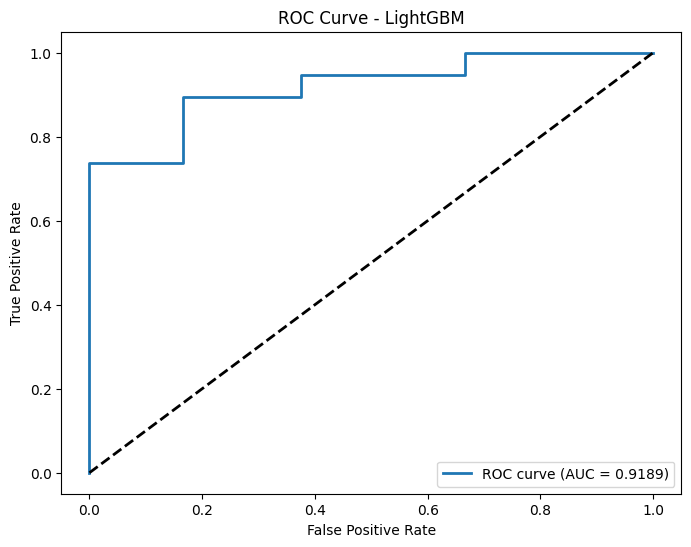

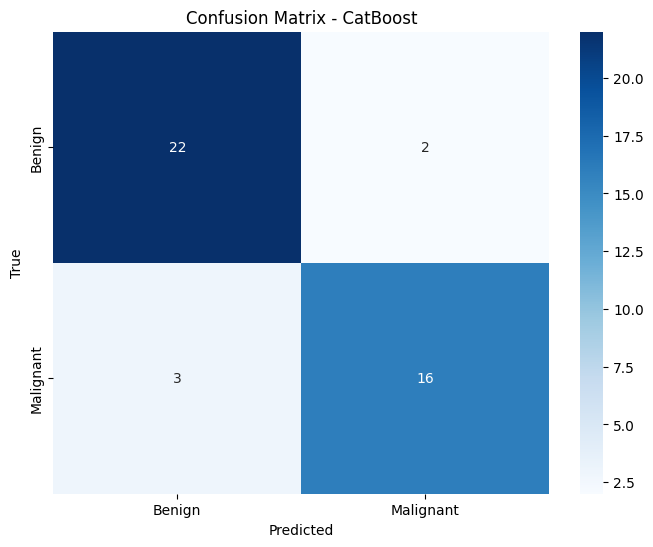

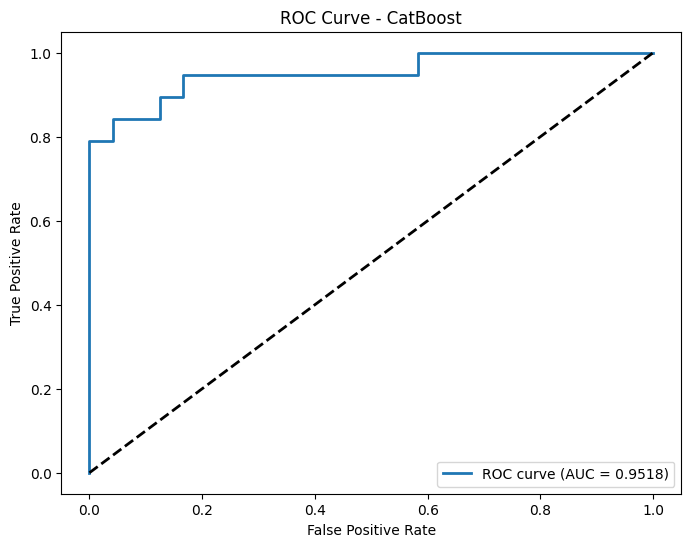

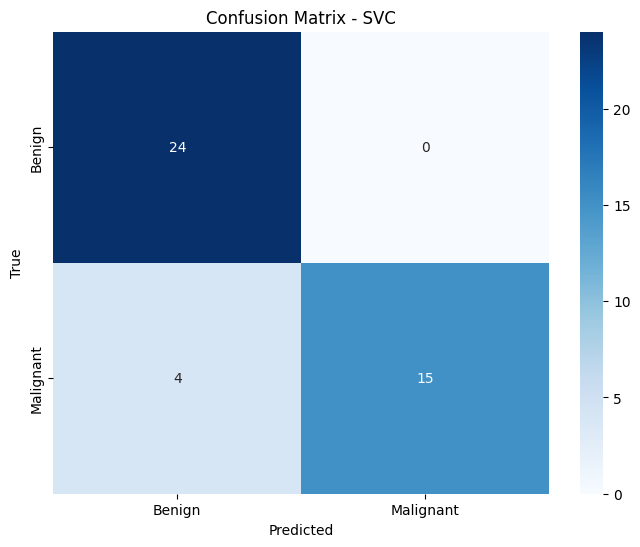

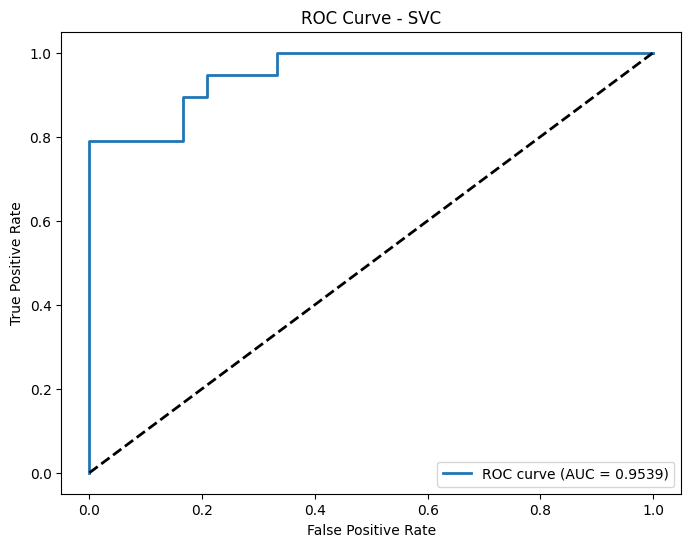

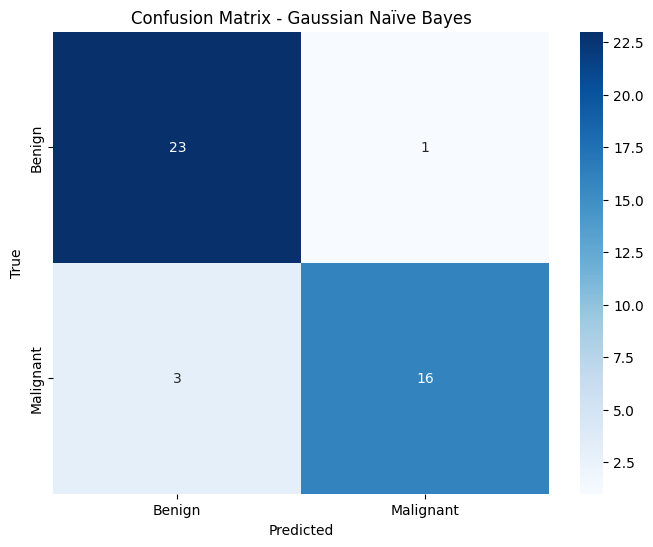

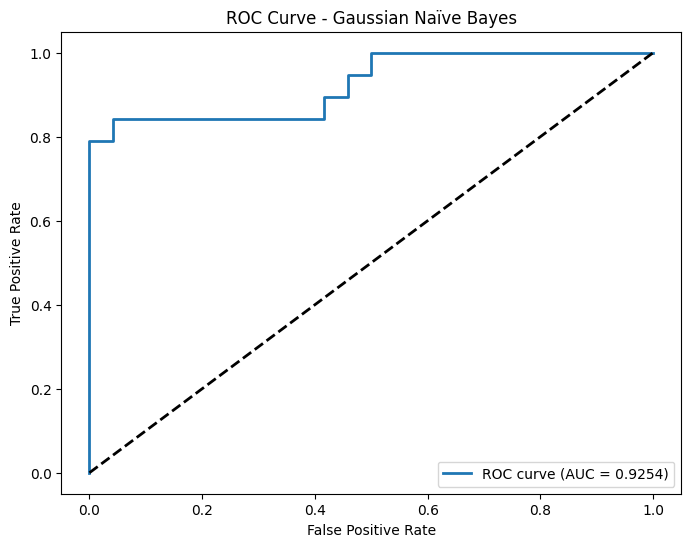

In [71]:
# Train and evaluate each model
results = []
for model_name, model in models.items():
    print(f"\n{'='*50}")
    print(f"Training {model_name}...")
    result = evaluate_model(model, X_train, X_test, y_train, y_test, model_name)
    results.append(result)


Best model based on cross-validation: Logistic Regression

Performing hyperparameter tuning for Logistic Regression...
Best parameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
Best cross-validation score: 0.8941

Tuned Logistic Regression Results:
Accuracy: 0.9070
Precision: 1.0000
Recall: 0.7895
F1 Score: 0.8824
Cross-Validation Accuracy: 0.8965 ± 0.0326

Classification Report:
              precision    recall  f1-score   support

           0       0.86      1.00      0.92        24
           1       1.00      0.79      0.88        19

    accuracy                           0.91        43
   macro avg       0.93      0.89      0.90        43
weighted avg       0.92      0.91      0.91        43

AUC Score: 0.9320


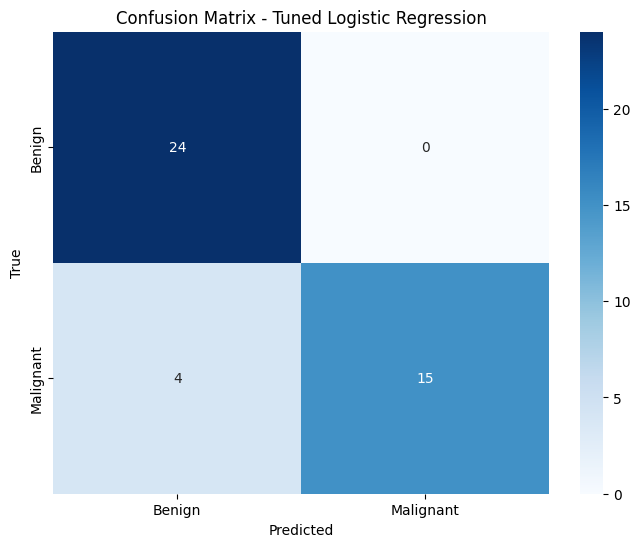

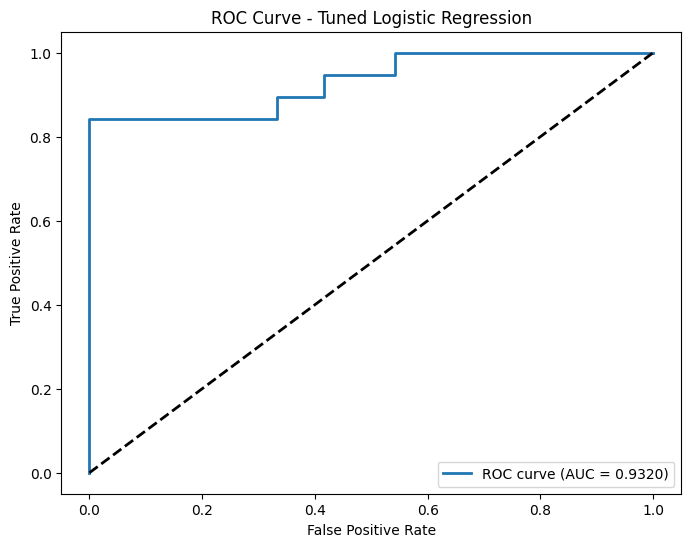

In [61]:
# 6. Hyperparameter Tuning for the best model

# Find the best model based on cross-validation score
best_model_info = max(results, key=lambda x: x['cv_score'])
best_model_name = best_model_info['model_name']
print(f"\nBest model based on cross-validation: {best_model_name}")

# Define hyperparameter grid for each model type
param_grids = {
    'Logistic Regression': {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'Extra Trees': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10]
    },
    'XGBoost': {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 6, 9],
        'learning_rate': [0.01, 0.1, 0.3]
    },
    'LightGBM': {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 6, 9],
        'learning_rate': [0.01, 0.1, 0.3]
    },
    'CatBoost': {
        'iterations': [50, 100, 200],
        'depth': [4, 6, 8],
        'learning_rate': [0.01, 0.1, 0.3]
    },
    'SVC': {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.1, 1],
        'kernel': ['rbf', 'linear', 'poly']
    },
    'Gaussian Naïve Bayes': {
        'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]
    }
}

# Perform hyperparameter tuning on the best model
print(f"\nPerforming hyperparameter tuning for {best_model_name}...")
grid_search = GridSearchCV(
    models[best_model_name],
    param_grids[best_model_name],
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Evaluate the tuned model
tuned_model = grid_search.best_estimator_
tuned_result = evaluate_model(tuned_model, X_train, X_test, y_train, y_test, f"Tuned {best_model_name}")

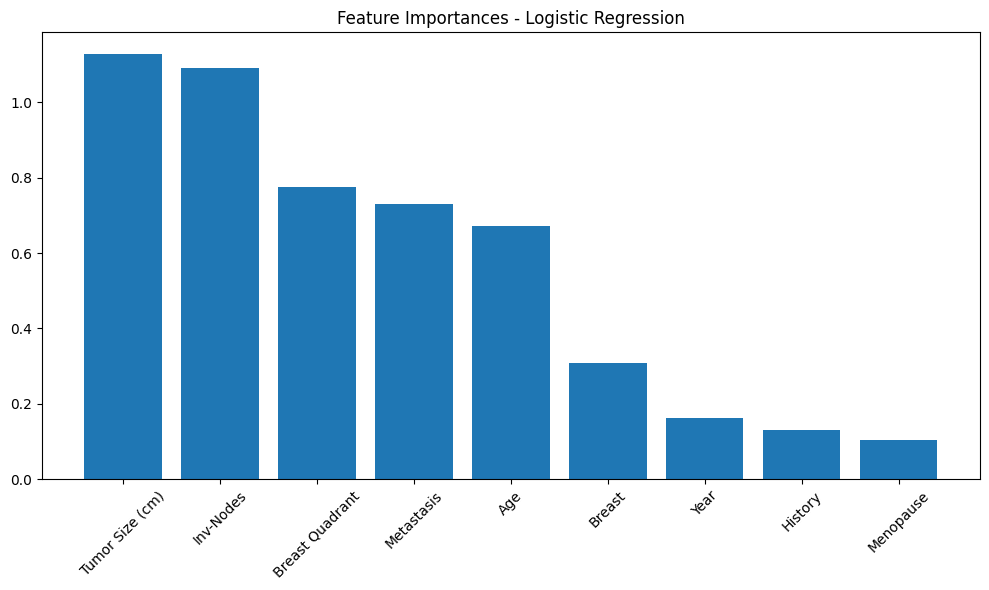


Top 10 most important features for Logistic Regression:
Tumor Size (cm): 1.1293
Inv-Nodes: 1.0903
Breast Quadrant: 0.7742
Metastasis: 0.7298
Age: 0.6712
Breast: 0.3089
Year: 0.1608
History: 0.1313
Menopause: 0.1034


In [69]:
def plot_feature_importance(model, feature_names, model_name):
    if model_name == 'Logistic Regression':
        coefs = model.coef_[0]
        indices = np.argsort(np.abs(coefs))[::-1]

        plt.figure(figsize=(10, 6))
        plt.title(f'Feature Importances - {model_name}')
        plt.bar(range(len(indices)), np.abs(coefs[indices]), align='center')
        plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=45)
        plt.tight_layout()
        plt.show()

        print(f"\nTop 10 most important features for {model_name}:")
        for i in range(min(10, len(indices))):
            print(f"{feature_names[indices[i]]}: {np.abs(coefs[indices[i]]):.4f}")

# Ensure model is trained
model = LogisticRegression(max_iter=2000)
model.fit(X_train, y_train)

# Plot feature importance
plot_feature_importance(model, X.columns, "Logistic Regression")



Model Comparison:
                  model_name  accuracy  precision    recall        f1  \
0        Logistic Regression  0.906977   1.000000  0.789474  0.882353   
6                        SVC  0.906977   1.000000  0.789474  0.882353   
0  Tuned Logistic Regression  0.906977   1.000000  0.789474  0.882353   
1              Random Forest  0.883721   0.937500  0.789474  0.857143   
7       Gaussian Naïve Bayes  0.906977   0.941176  0.842105  0.888889   
5                   CatBoost  0.883721   0.888889  0.842105  0.864865   
2                Extra Trees  0.813953   0.823529  0.736842  0.777778   
4                   LightGBM  0.813953   0.789474  0.789474  0.789474   
3                    XGBoost  0.813953   0.789474  0.789474  0.789474   

   cv_score  
0  0.901329  
6  0.896456  
0  0.896456  
1  0.887265  
7  0.887043  
5  0.882614  
2  0.873200  
4  0.854374  
3  0.849834  


<Figure size 1200x800 with 0 Axes>

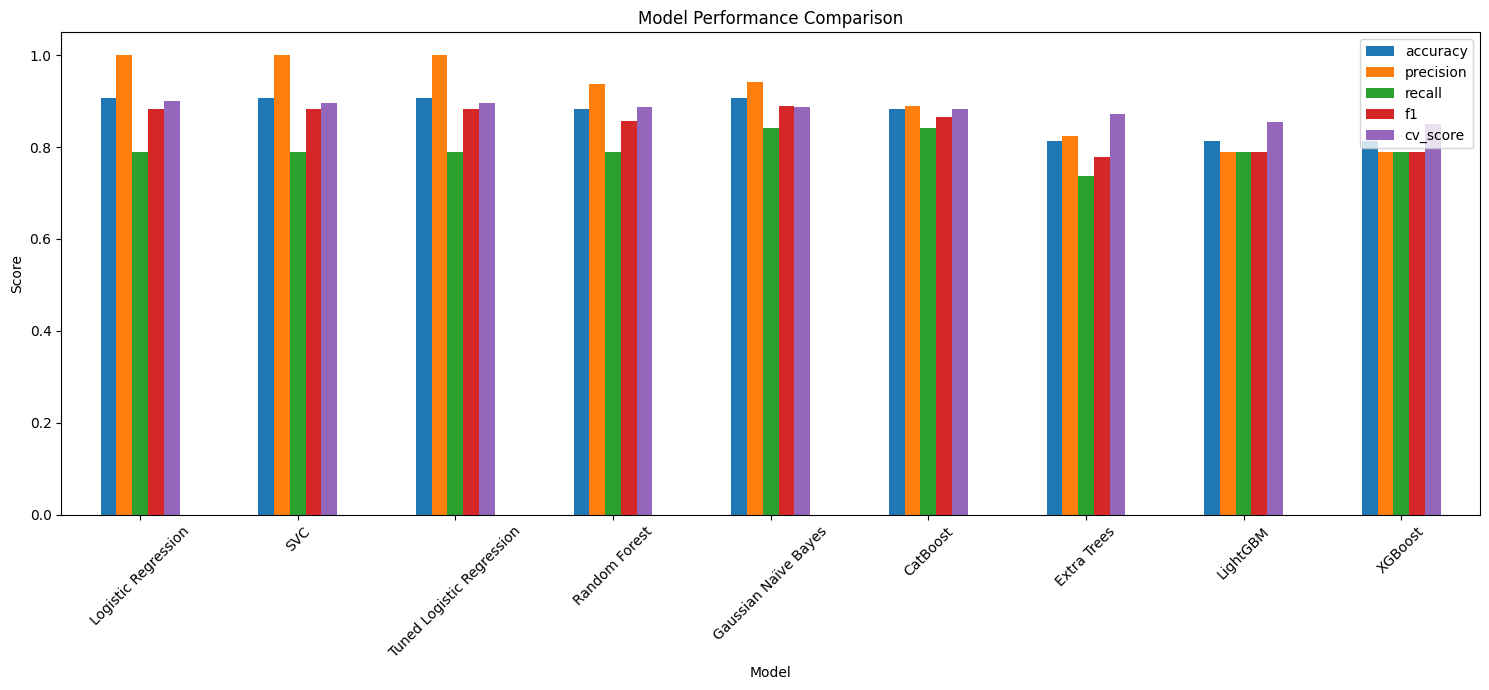

In [66]:
# 8. Compare all models' performance

# Create a comparison DataFrame
comparison_df = pd.DataFrame(results)
comparison_df = comparison_df[['model_name', 'accuracy', 'precision', 'recall', 'f1', 'cv_score']]

# Add tuned model results
tuned_row = pd.DataFrame({
    'model_name': [f"Tuned {best_model_name}"],
    'accuracy': [tuned_result['accuracy']],
    'precision': [tuned_result['precision']],
    'recall': [tuned_result['recall']],
    'f1': [tuned_result['f1']],
    'cv_score': [tuned_result['cv_score']]
})
comparison_df = pd.concat([comparison_df, tuned_row])

# Sort by cross-validation score
comparison_df = comparison_df.sort_values('cv_score', ascending=False)

print("\nModel Comparison:")
print(comparison_df)

# Visualize model comparison
plt.figure(figsize=(12, 8))
comparison_df_plot = comparison_df.set_index('model_name')
comparison_df_plot.plot(kind='bar', figsize=(15, 7))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('model_comparison.png')
# plt.show()


Creating Voting Classifier with top models...

Voting Classifier Results:
Accuracy: 0.9070
Precision: 1.0000
Recall: 0.7895
F1 Score: 0.8824
Cross-Validation Accuracy: 0.8966 ± 0.0246

Classification Report:
              precision    recall  f1-score   support

           0       0.86      1.00      0.92        24
           1       1.00      0.79      0.88        19

    accuracy                           0.91        43
   macro avg       0.93      0.89      0.90        43
weighted avg       0.92      0.91      0.91        43

AUC Score: 0.9518

Final Model Rankings:
                  model_name  accuracy  precision    recall        f1  \
0        Logistic Regression  0.906977   1.000000  0.789474  0.882353   
0          Voting Classifier  0.906977   1.000000  0.789474  0.882353   
6                        SVC  0.906977   1.000000  0.789474  0.882353   
0  Tuned Logistic Regression  0.906977   1.000000  0.789474  0.882353   
1              Random Forest  0.883721   0.937500  0.78947

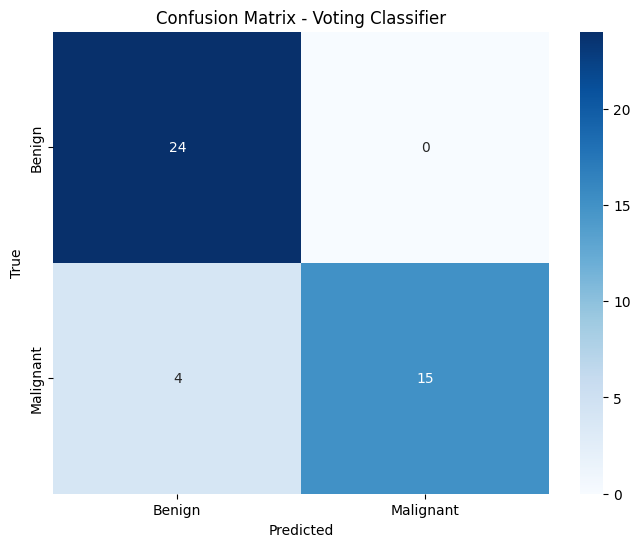

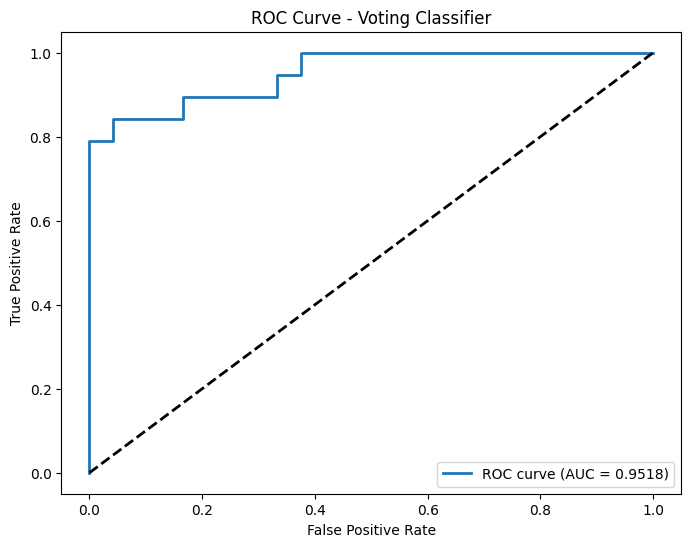

In [67]:
# 9. Voting Classifier with top 3 models
from sklearn.ensemble import VotingClassifier

# Get the top 3 models
top_models = comparison_df.head(3)['model_name'].tolist()
top_models = [m for m in top_models if not m.startswith('Tuned')]  # Exclude tuned model to avoid duplication

if top_models:
    print("\nCreating Voting Classifier with top models...")
    estimators = [(model_name, models[model_name]) for model_name in top_models]
    
    # Add the tuned model
    estimators.append((f"Tuned {best_model_name}", tuned_model))
    
    # Create and evaluate Voting Classifier
    voting_clf = VotingClassifier(estimators=estimators, voting='soft')
    voting_result = evaluate_model(voting_clf, X_train, X_test, y_train, y_test, "Voting Classifier")
    
    # Add to comparison DataFrame
    voting_row = pd.DataFrame({
        'model_name': ["Voting Classifier"],
        'accuracy': [voting_result['accuracy']],
        'precision': [voting_result['precision']],
        'recall': [voting_result['recall']],
        'f1': [voting_result['f1']],
        'cv_score': [voting_result['cv_score']]
    })
    comparison_df = pd.concat([comparison_df, voting_row])
    
    # Final rankings
    print("\nFinal Model Rankings:")
    comparison_df = comparison_df.sort_values('cv_score', ascending=False)
    print(comparison_df)

In [68]:
# 10. Save the best model
import pickle

# Save the best model to disk
best_final_model = max(comparison_df.iterrows(), key=lambda x: x[1]['cv_score'])
best_final_model_name = best_final_model[1]['model_name']

if best_final_model_name == "Voting Classifier":
    final_model = voting_clf
elif best_final_model_name.startswith("Tuned"):
    final_model = tuned_model
else:
    final_model = models[best_final_model_name]

print(f"\nSaving the best model: {best_final_model_name}")
with open('best_breast_cancer_model.pkl', 'wb') as f:
    pickle.dump(final_model, f)

print("\nSaving the scaler for preprocessing new data")
with open('breast_cancer_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# 11. Example prediction function for new data
def predict_breast_cancer(new_data, model, scaler):
    """
    Make predictions on new patient data
    
    Parameters:
    new_data (pd.DataFrame): DataFrame containing patient features (same as training features)
    model: Trained model
    scaler: Fitted scaler
    
    Returns:
    prediction: 0 (Benign) or 1 (Malignant)
    probability: Probability of malignancy
    """
    # Preprocess the data (handle categorical variables, etc.)
    # Apply the same transformations as in training
    
    # Scale the features
    new_data_scaled = scaler.transform(new_data)
    
    # Make prediction
    prediction = model.predict(new_data_scaled)[0]
    
    # Get probability if the model supports it
    if hasattr(model, "predict_proba"):
        probability = model.predict_proba(new_data_scaled)[0, 1]
    else:
        probability = None
    
    return prediction, probability

# Example usage of prediction function:
print("\nExample of using the model for prediction:")
print("To predict for a new patient, prepare data in the same format as training features")
print("and use the provided predict_breast_cancer function.")

print("\nAnalysis Complete! The best model for breast cancer prediction is:", best_final_model_name)


Saving the best model: Logistic Regression

Saving the scaler for preprocessing new data

Example of using the model for prediction:
To predict for a new patient, prepare data in the same format as training features
and use the provided predict_breast_cancer function.

Analysis Complete! The best model for breast cancer prediction is: Logistic Regression
